In [4]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 20,
          'text.fontsize': 16,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)


# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


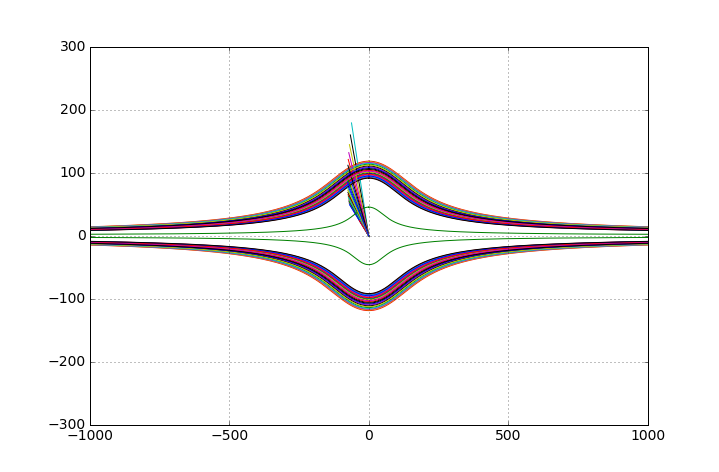

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True


In [83]:
# Q_EL = 1.602e-19
# M_EL = 9.1e-31
eo   = 8.854e-12
c    = 2.998e8

# rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/ray_200.ray')
rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/',200, 0, 60, 0,0)



s = 0 # species index
t = 0
# f = np.arange(200, 100000, 10)

# w = f*(2*np.pi)
theta = np.linspace(0, 2*np.pi, 5000)

root = -1    
plt.figure()

for ray in rf:
#     print ray.keys()
    w = ray['w']
    B   =  ray['B0'].iloc[t]
    Bmag = np.linalg.norm(B)
#     print np.linalg.norm(B)
    Q    = np.abs(ray['qs'].iloc[t,s])
    M    = ray['ms'].iloc[t,s]
    Ns   = ray['Ns'].iloc[t,s]
    n    = (ray['n'].iloc[t])
    
    Wh   = Q*Bmag/M
    Wh2  = pow(Wh,2)
    Wp2  = Ns*pow(Q,2)/eo/M
    Wp   = np.sqrt(Wp2)
    
    # Angle between wavenormal ( || n ) and background field 
#     theta = 0
#     print "theta ", theta*180/np.pi
#     print "Wh ", Wh
#     print "Wp ", Wp

    # Calculate mu^2 using Appleton-Hartree    
    numerator = Wp2/w/w
    denom1  = (Wh2*pow(np.sin(theta),2))/2/(pow(w,2) - Wp2)
    
    denom2  = np.sqrt(pow(denom1,2) + (Wh*Wh)*pow(np.cos(theta),2)/pow(w,2))
  
    mu2_calc = (1 - numerator/(1 - denom1 + root*denom2))
    
    theta_file = np.dot(B,n)/(np.linalg.norm(B)*np.linalg.norm(n))
    mu_file = np.linalg.norm(n)
    mu2_file = pow(mu_file, 2)
    
    print (Wp >= Wh >= w)
#     print "mu2_calc:", mu2_calc
#     print "mu2_file:", mu2_file
    
    k2 = mu2_calc*w*w/c/c
#     plt.plot(theta*180./np.pi, np.sqrt(mu2_calc))
#     plt.plot(theta*180./np.pi, np.ones_like(mu2_calc)*np.sqrt(mu2_file))
    plt.plot(np.sqrt(mu2_calc)*np.sin(theta), np.sqrt(mu2_calc)*np.cos(theta))
    
    plt.plot([0, mu_file*np.sin(theta_file)], [0, mu_file*np.cos(theta_file)])
    plt.xlim([-1000, 1000])
    plt.ylim([-300, 300])
    plt.grid()
    
    

In [7]:

def stix_parameters(ray, t):

    w = ray['w']
    B   =  ray['B0'].iloc[t]
    Bmag = np.linalg.norm(B)
    #     print np.linalg.norm(B)
    Q    = np.abs(np.array(ray['qs'].iloc[t,:]))
    M    = np.array(ray['ms'].iloc[t,:])
    Ns   = np.array(ray['Ns'].iloc[t,:])
    n    = (ray['n'].iloc[t])

    Wcs   = Q*Bmag/M
    Wps2  = Ns*pow(Q,2)/eo/M

    R = 1.0 - np.sum(Wps2/(w*(w + Wcs)))
    L = 1.0 - np.sum(Wps2/(w*(w - Wcs)))
    P = 1.0 - np.sum(Wps2/(w*w))
    S = 1.0/(2.0*(R+L))
    D = 1.0/(2.0*(R-L))

    return R, L, P, S, D


# # Dispersion relation via Stix params:
# t = 0
# ray = rf[0]
# n = ray['n'].iloc[t]
# B0   =  ray['B0'].iloc[t]

# R, L, P, S, D = stix_parameters(ray, t)

# nmag2 = np.dot(ray['n'].iloc[t], ray['n'].iloc[t])

# cos2phi = (np.dot(n, B0)*np.dot(n, B0))/(np.dot(n,n)*np.dot(B0, B0))
# sin2phi = 1.0 - cos2phi

# A = S*sin2phi + P*cos2phi
# B = R*L*sin2phi + P*S*(1.0 + cos2phi)

# dispersion_relation = A*pow(nmag2,2) - B*nmag2 + R*L*P


<IPython.core.display.Javascript object>


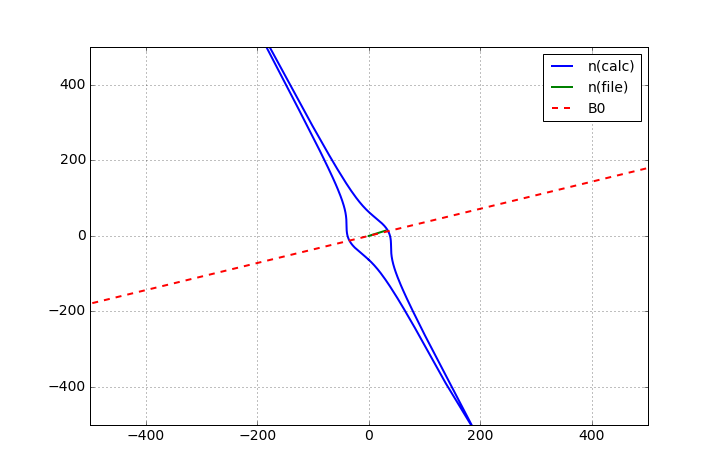

In [262]:
# clone of solve_dispersion_relation.f95:
import xflib
eo = 8.854e-12
c = 2.998e8

def s2c(p):
#     % Convert the input position (rho,theta,phi) to (x,y,z)
    x = np.zeros(3);
    x[0] = p[0]*np.cos(p[1])*np.sin(p[2]);
    x[1] = p[0]*np.sin(p[1])*np.sin(p[2]);
    x[2] = p[0]*np.cos(p[2]);
  
    return x

def c2s(x):
    p = np.zeros(3)
    p[0] = np.sqrt(np.sum(x**2))
    p[1] = np.atan2(x[1], x[0])

    if p[0] != 0:
        p[2] = np.arccos(x[2]/x[0]) 

def solve_dispersion_relation(ray, t, root=2, nvec = None):
    if nvec is None:
        n = ray['n'].iloc[t]
    else:
        n = nvec
        
    B0   =  ray['B0'].iloc[t]
    w = ray['w']
    
    R, L, P, S, D = stix_parameters(ray, t)

    cos2phi = (np.dot(n, B0)*np.dot(n, B0))/(np.dot(n,n)*np.dot(B0, B0))
    sin2phi = 1.0 - cos2phi

    A = S*sin2phi + P*cos2phi
    B = R*L*sin2phi + P*S*(1.0 + cos2phi)
    discriminant = B**2 - 4.0*A*R*L*P

    n1sq = ((B + np.sqrt(discriminant))/(2.0*A))
    n2sq = ((B - np.sqrt(discriminant))/(2.0*A))
    
#     print n1sq, n2sq
    n1 = np.sqrt(n1sq)
    n2 = np.sqrt(n2sq)
    
#     print n1, n2
    if abs(n1) > abs(n2):
        k2 = w*n1/c
        k1 = w*n2/c
    else:
        k1 = w*n1/c
        k2 = w*n2/c
    
    if root==1.0:
        k = k1
    else:
        k = k2
    return k
#     return k1, k2


# --------- Plot (3d?) refractive index surface:
rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/',200, 0, 60, 0,0)

t = 10
ray = rf[5]

B_file = ray['B0'].iloc[t,:]
n_file = ray['n'].iloc[t,:]
# file angle between n and B:
theta_file = -np.dot(B_file,n_file)/(np.linalg.norm(B_file)*np.linalg.norm(n_file))
# file mu: 
mu_file = np.linalg.norm(n_file)



theta_vec = [0]
phi_vec   = np.linspace(-np.pi, np.pi, 500)
kc_vec = []
for theta in theta_vec:
    for phi in phi_vec:
        n = s2c([1.0, theta, phi])
        k = solve_dispersion_relation(ray, t, root=2, nvec=n)
        kcart = s2c([k, theta, phi]);
        kc_vec.append(kcart)
        

n_vec = np.asarray(kc_vec)*c/ray['w']

# B = ray['B0'].iloc[t,:]
# n = ray['n'].iloc[t,:]
# theta_file = np.dot(B,n)/(np.linalg.norm(B)*np.linalg.norm(n))
# mu_file = np.linalg.norm(n)

# print theta_file
# print mu_file


Bdir = 1000.*B/np.linalg.norm(B)
Bx   = np.sqrt(Bdir[0]**2 + Bdir[1]**2)

plt.figure()

plt.plot(np.sign(n_vec[:,0])*np.sqrt(n_vec[:,0]**2 + n_vec[:,1]**2),
         n_vec[:,2],'b', linewidth=2, label='n(calc)')
plt.plot([0, np.sqrt(n_file[0]**2 + n_file[1]**2)],
         [0, n_file[2]], 'g', linewidth=2, label='n(file)')
plt.plot([-Bx, Bx], [-Bdir[2], Bdir[2]], 'r--', linewidth=2, label='B0')
plt.grid()

ps = 500
plt.ylim([-ps, ps])
plt.xlim([-ps, ps])
plt.legend()


<IPython.core.display.Javascript object>


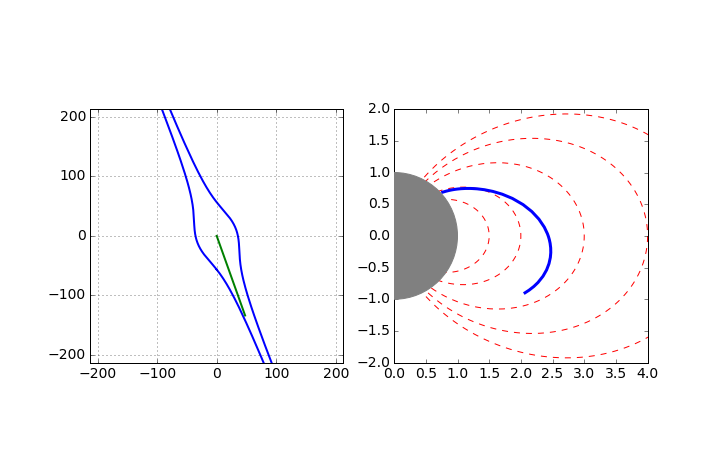

In [284]:
rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/',1010, 0, 60, 0,0)

ray = rf[10]
t_ind = 50

B_file = ray['B0'].iloc[t_ind,:]
n_file = ray['n'].iloc[t_ind, :]

# file mu: 
mu_file = np.linalg.norm(n_file)

# refractive index surface (calc):
phi_vec   = np.linspace(-np.pi, np.pi, 500)
kc_vec = np.zeros([len(phi_vec), 3])
for ind, phi in enumerate(phi_vec):
    n = s2c([1.0, 0.0, phi])
    k = solve_dispersion_relation(ray, t_ind, root=2, nvec=n)
    kcart = s2c([k, theta, phi]);
#     kc_vec.append(kcart)
    kc_vec[ind, :] = kcart
        

n_vec = kc_vec*c/ray['w']


fig, ax = plt.subplots(1, 2)
D2R = np.pi/180.
R_E = 6371e3

L_shells = [1.5, 2, 3, 4, 5]
# Ray plot on right:
ax[1].set_aspect("equal")
psize = 4

# Plot the earth
earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
ax[1].add_patch(earth)                    # The earth (round)

# Plot the fieldlines
for L in L_shells:
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax[1].plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')  # Field line

# Plot ray up to t:
r = ray['pos'].iloc[0:t_ind, :]
ax[1].plot(np.sqrt(r.x*r.x + r.y*r.y)/R_E, r.z/R_E, linewidth=3)

ps1 = 4
ax[1].set_xlim([0, ps1])
ax[1].set_ylim([-ps1/2., ps1/2.])
# plot refractive index surface:
ax[0].plot(np.sign(n_vec[:,0])*np.sqrt(n_vec[:,0]**2 + n_vec[:,1]**2),
         n_vec[:,2],'b', linewidth=2, label='n(calc)')
ax[0].plot([0, np.sqrt(n_file[0]**2 + n_file[1]**2)],
         [0, n_file[2]], 'g', linewidth=2, label='n(file)')
ax[0].grid()

ps0 = np.linalg.norm(n_file)*1.5
ax[0].set_ylim([-ps0, ps0])
ax[0].set_xlim([-ps0, ps0])
# ax[0].legend()
ax[0].set_aspect('equal')




In [ ]:
# Dispersion relation via Appleton-Hartree
# Q_EL = 1.602e-19
# M_EL = 9.1e-31
eo   = 8.854e-12
c    = 2.998e8

# rf = read_rayfile('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/ray_200.ray')
rf = read_rayfiles('/shared/users/asousa/WIPP/3dWIPP/outputs/low_f_debugging/',1010, 0, 60, 0,0)



s = 0 # species index
t = 0

#theta = np.linspace(0, 2*np.pi, 5000)

root = -1    
plt.figure()

for ray in rf:
#     print ray.keys()
    w = ray['w']
    B   =  ray['B0'].iloc[t]
    Bmag = np.linalg.norm(B)
#     print np.linalg.norm(B)
    Q    = np.abs(ray['qs'].iloc[t,s])
    M    = ray['ms'].iloc[t,s]
    Ns   = ray['Ns'].iloc[t,s]
    n    = (ray['n'].iloc[t])
    
    Wh   = Q*Bmag/M
    Wh2  = pow(Wh,2)
    Wp2  = Ns*pow(Q,2)/eo/M
    Wp   = np.sqrt(Wp2)
    
    # Angle between wavenormal ( || n ) and background field 
#     theta = 0
#     print "theta ", theta*180/np.pi
#     print "Wh ", Wh
#     print "Wp ", Wp

    # Calculate mu^2 using Appleton-Hartree    
    numerator = Wp2/w/w
    denom1  = (Wh2*pow(np.sin(theta),2))/2/(pow(w,2) - Wp2)
    
    denom2  = np.sqrt(pow(denom1,2) + (Wh*Wh)*pow(np.cos(theta),2)/pow(w,2))
  
    mu2_calc = (1 - numerator/(1 - denom1 + root*denom2))
    
    theta_file = np.dot(B,n)/(np.linalg.norm(B)*np.linalg.norm(n))
    mu_file = np.linalg.norm(n)
    mu2_file = pow(mu_file, 2)
    
    print (Wp >= Wh >= w)
#     print "mu2_calc:", mu2_calc
#     print "mu2_file:", mu2_file
    
    k2 = mu2_calc*w*w/c/c
#     plt.plot(theta*180./np.pi, np.sqrt(mu2_calc))
#     plt.plot(theta*180./np.pi, np.ones_like(mu2_calc)*np.sqrt(mu2_file))
    plt.plot(np.sqrt(mu2_calc)*np.sin(theta), np.sqrt(mu2_calc)*np.cos(theta))
    
    plt.plot([0, mu_file*np.sin(theta_file)], [0, mu_file*np.cos(theta_file)])
    plt.xlim([-1000, 1000])
    plt.ylim([-300, 300])
    plt.grid()
    
    